## Experimental: my own work

Some example problems are (increasing complexity):
- FBPass for a single conv layer: Find loss gradient for both kernel and input.
- Add bias and an activation function (AF).
- Add a pooling layer, and a fully connected dense layer ( This will give full score! )

In [630]:

import numpy as np
import matplotlib.pyplot as plt
import math


In [664]:
def visualize_image(X, label):
    # Plot "pixels" with numerical value and color map
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(1,1,1)
    ax.axis('off')
    ax.imshow(X, cmap="coolwarm")
    ax.title.set_text(label)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            ax.text(j, i, f"{X[i,j]:.2f}", color="black", fontsize="small", ha="center", va="center")

edge1 = np.array([[0,0,0,0,0, 0], [0,1,1,0,0,0], [0,1,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
edge2 = np.array([[0,0,0,0,0, 0], [0,0,1,1,0,0], [0,0,1,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
edge3 = np.array([[0,0,0,0,0, 0], [0,0,0,0,0,0], [0,0,0,1,1,0], [0,0,0,1,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])

no_edge1 = np.array([[1,0,0,1,0,0], [0,0,0,1,0,0], [1,0,0,0,0,0], [0,0,0,0,0,1], [0,0,0,0,1,0], [0,0,0,0,0,0]])
no_edge2 = np.array([[0,0,0,1,0,0], [0,0,0,1,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,1,0,0]])
no_edge3 = np.array([[0,1,0,0,0,0], [0,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,0,0], [0,0,0,1,0,0], [0,0,0,0,0,0]])

singles1 = np.array([[0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
singles2 = np.array([[0,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
singles3 = np.array([[0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])


y_train = np.array([1, 1, 1, 0, 0, 0]) # 1 is edge, 0 is no edge
#X_train = np.asarray([edge1, edge2, edge3, no_edge1, no_edge2, no_edge3])
X_train = np.asarray([edge1, edge2, edge3, singles1, singles2, singles3])

X_train.shape

(6, 6, 6)

### Simplest case - binary classification
A single convolutional layer, then a a dense layer.

In [148]:
def convolution(X, F, b=0, s=1):
    # Convolutional layer
    # note: no padding and depth=1 just to make calculations a bit simpler
    # Output feature size
    w_out = (X.shape[0] - F.shape[0])//s + 1
    h_out = (X.shape[1] - F.shape[1])//s + 1
    z = np.zeros((h_out, w_out))
    for j in range(0, w_out, s):
        for i in range(0, h_out, s):
            z[i,j] = X[i:i+F.shape[1], j:j+F.shape[0]].flatten().dot(F.flatten()) + b
    return z

def max_pool(X, k, s):
    h_out = (X.shape[0] - k)//s + 1
    w_out = (X.shape[1] - k)//s + 1
    z = np.zeros((h_out, w_out))
    idx = []
    for j in range(0, h_out):
        for i in range(0, w_out):
            block = X[j*k:j*k+k, i*k:i*k+k]
            z[j,i] = np.max(block)
            index = np.add(np.unravel_index(block.argmax(), block.shape), (j*k, i*k))
            idx.append(index) # Save indices of max values for backward pass!
    return z, idx
    
def ReLU(x):
    return abs(x) * (x > 0) # abs just makes -0.0 into 0.0 for easier reading
def d_ReLU(x): # differentiated!
    return 1 * (x > 0)
def sigmoid(x):
    y = np.exp(x)
    return y / (1 + y)
def d_sigmoid(x): # differentiated!
    y = sigmoid(x)
    return y * (1.0 - y)
def bce_loss(y, p):
    # Binary cross-entropy loss function
    return -(y * np.log10(p) + (1-y) * np.log10(1-p))
def d_bce_loss(y,p): # differentiated!
    # Derivative wrt. p
    return (1 - y) / (1 - p) - (y / p)

In [632]:
def simple_fit(X_train, y_train, lr=0.1, epochs=10, verbose=False, scale=255):
    # Initialize randomly
    b1 = 1.0 # conv Bias
    F = np.array([[-0.5,0.5, -0.5],[-0.5,0.5, -0.5], [-0.5,0.5, -0.5]]) # Kernel
    #F = np.array([[0.1,-0.1],[-0.1,0.1]]) # Kernel
    w4 = None 
    b4 = 0 # neuron Bias
    lr = 0.1 # Leanring rate
    losses = []

    for e in range(epochs):
        for i, X in enumerate(X_train):        
            X = X/scale # normalize
            ####################
            ### Forward pass ###
            ####################
            # Convolution
            z1 = convolution(X, F, b1, s=1) # Perform convolution
            a1 = ReLU(z1) # Apply AF
            # Maxpool and flatten
            a2, max_idx = max_pool(a1, k=2, s=2)
            a3 = a2.flatten()
            # Initialize to correct size
            if e==0 and i==0:
                w4 = np.random.randn(len(a3))
            # Fully-connected layer
            z4 = w4.dot(a3) + b4
            a4 = sigmoid(z4)
            # Loss
            loss = bce_loss(y_train[i], a4)
            losses.append(loss)

            ####################
            ### Backward pass ##
            ####################
            # Fully connected layer:
            delta = d_bce_loss(y_train[i], a4) * d_sigmoid(z4)
            b4 = b4 - lr * delta # Update bias
            delta = delta * a3 # Gradient wrt. w4
            w4 = w4 - lr * delta # Update weights

            # NEXT, we unflatten the backpropagated derivative:
            delta = delta.reshape(a2.shape)
            # maxpooling layer
            d = np.zeros(a1.shape)
            for idx, grad in zip(max_idx, delta.flatten()):
                i, j = idx[0], idx[1]
                d[i,j] = grad
            delta = d
            # Backprop through delta
            delta = d_ReLU(z1) * delta
            # The conv bias
            grad_b1 = delta.sum() # dL/d(b1)
            b1 = b1 - lr * grad_b1 # Update bias
            # The conv kernel
            grad_F = convolution(X, delta)
            F = F - lr * grad_F # Update weights

        if verbose:
            print("Epoch:", e)
            print("loss:", losses[-1])


    model = {"b1":b1, "F":F, "b4":b4, "w4":w4}
    if math.isnan(losses[-1]):
        print("Could not find minima, restarting")
        return simple_fit(X_train, y_train, lr=lr, epochs=epochs, verbose=verbose, scale=scale)
    return model, losses
        

def prediction(model, test_data, scale=255):
    predictions = np.zeros(len(test_data))
    for i, X in enumerate(test_data):
        X = X/scale # normalize
        b1 = model["b1"]
        F = model["F"]
        b4 = model["b4"]
        w4 = model["w4"]
        ####################
        ### Forward pass ###
        ####################
        # Convolution
        z1 = convolution(X, F, b1, s=1) # Perform convolution
        a1 = ReLU(z1) # Apply AF
        # Maxpool and flatten
        a2, max_idx = max_pool(a1, k=2, s=2)
        a3 = a2.flatten()
        # Fully-connected layer
        z4 = w4.dot(a3) + b4
        a4 = sigmoid(z4)
        # Loss
        predictions[i] = a4
    return predictions

#### Let us test the simple framework: Edge detection

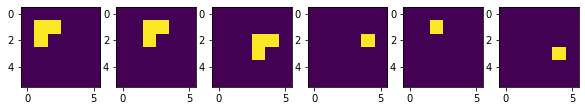

In [665]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(10, 15))
# plotting the loss
axs[0].imshow(X_train[0])
axs[1].imshow(X_train[1])
axs[2].imshow(X_train[2])
axs[3].imshow(X_train[3])
axs[4].imshow(X_train[4])
axs[5].imshow(X_train[5]);

In [673]:
model, losses = simple_fit(X_train, y_train, lr=0.1, epochs=400, verbose=False, scale=1)

c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting


c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
c:\Users\henri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting
Could not find minima, restarting


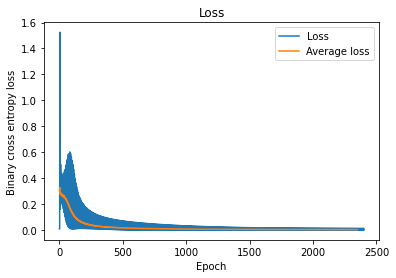

In [674]:
# Average loss over time
N=50
avg = np.convolve(losses, np.ones(N)/N, mode='valid')
# plotting the loss
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross entropy loss")
plt.plot(np.linspace(0, len(losses), len(losses)), losses, label="Loss")
plt.plot(np.linspace(0, len(avg), len(avg)), avg, label="Average loss")
plt.legend();

In [675]:
prediction(model, X_train, scale=1)

array([9.94762861e-01, 9.92434816e-01, 1.00000000e+00, 8.02225966e-04,
       1.60072354e-02, 1.03805862e-06])

#### Will it recognize some new data?

(array([1.]), array([0.00705104]))

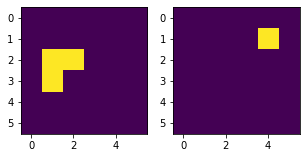

In [676]:
edge4 = np.array([[0,0,0,0,0, 0], [0,0,0,0,0,0], [0,1,1,0,0,0], [0,1,0,0,0,0], [0,0,0,0,0,0], [0, 0, 0, 0, 0, 0]])
singles4 = np.array([[0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0, 0, 0, 0, 0, 0]])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 8))
# plotting the loss
axs[0].imshow(edge4)
axs[1].imshow(singles4)

prediction(model, [edge4], scale=1), prediction(model, [singles4], scale=1)


#### From the article
https://medium.com/analytics-vidhya/creating-convolutional-neural-networks-from-scratch-6daaa6b9eea0

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoid_p(x):
    return sigmoid(x)*(1 -sigmoid(x))
def relu(x):
    return np.maximum(x, 0)
def relu_p(x):
    return np.heaviside(x, 0)
def deriv_func(z,function):
    if function == sigmoid:
        return sigmoid_p(z)
    elif function == relu:
        return relu_p(z)